# **Visualisations**

This section presents key visual insights that support the analysis of climate tipping points. Through scatterplots, boxplots, and regression visuals, the relationships between renewable energy adoption, energy intensity, and CO₂ emissions per capita are explored. These visualisations help uncover patterns, outliers, and potential thresholds critical to understanding the dynamics of global decarbonisation efforts.



In [1]:
# import libraries
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.stats as stats

# load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features.csv')
df.head()

,country,year,elec_access_pct,clean_fuels_access_pct,renew_cap_kw_pc,climate_finance_usd,renewables_share_pct,fossil_elec_twh,nuclear_elec_twh,renew_elec_twh,...,region_miss,subregion_miss,co2_per_capita_t,log_co2_per_capita_t,log_renewables_share_pct,log_energy_intensity_mj_usd,log_gdp_pc_usd,above_30_pct,year_offset,renewables_3yr_avg
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,0,0,0.037754,0.037059,3.828424,0.970779,5.195324,1,0,44.990000
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,0,0,0.035988,0.035356,3.841601,1.007958,5.195324,1,1,45.295000
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,0,0,0.048180,0.047055,3.659193,0.875469,5.195324,1,2,42.806667
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,0,0,0.053666,0.052276,3.628599,0.875469,5.255847,1,3,40.030000
4,Afghanistan,2004,20.064968,10.9,7.75,0.0,44.24,0.33,0.0,0.56,...,0,0,0.043717,0.042788,3.811982,0.788457,5.358387,1,4,39.576667


In [ ]:
# Group countries by region and subregion

import pandas as pd

# Load & clean
df = (
    pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
      .loc[:, ['region', 'subregion', 'country']]
      .dropna()
      .drop_duplicates()
)

# Group & join countries
grouped = (
    df
    .groupby(['region', 'subregion'])['country']
    .apply(lambda lst: ", ".join(sorted(lst)))
    .reset_index(name="Countries")
)

# Compute column widths
cols = ['Region', 'Subregion', 'Countries']
widths = [
    max(grouped['region'].map(len).max(), len(cols[0])),
    max(grouped['subregion'].map(len).max(), len(cols[1])),
    max(grouped['Countries'].map(len).max(), len(cols[2])),
]

# Prepare formats
header_fmt = f"{{:<{widths[0]}}} | {{:<{widths[1]}}} | {{:<{widths[2]}}}"
separator  = f"{'-'*widths[0]}-+-{'-'*widths[1]}-+-{'-'*widths[2]}"
row_fmt    = header_fmt

# Print table
print(header_fmt.format(*cols))
print(separator)
for _, row in grouped.iterrows():
    print(row_fmt.format(row['region'], row['subregion'], row['Countries']))


Region   | Subregion                       | Countries                                                                                                                                                                                                                                                                                                                                                                                                                                                           
---------+---------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Afri

In [48]:
# Energy Mix Transition by Subregion (Sankey Plot)

import pandas as pd
import plotly.graph_objects as go

# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')  

# Step 1: Aggregate average renewables share by subregion
df_subregion = df[['subregion', 'renewables_share_pct']].dropna()
avg_renew = df_subregion.groupby('subregion')['renewables_share_pct'].mean().reset_index()

# Step 2: Categorise by level of renewable energy share
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Step 3: Prepare for Sankey
sankey_df = avg_renew[['subregion', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['subregion'].unique()) + list(sankey_df['category'].unique())
label_to_index = {label: i for i, label in enumerate(labels)}

sources = sankey_df['subregion'].map(label_to_index).tolist()
targets = sankey_df['category'].map(label_to_index).tolist()
values = sankey_df['count'].tolist()

# Step 4: Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgreen"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 128, 0, 0.3)"
    )
)])

fig.update_layout(
    title_text="Energy Mix Transition by Subregion (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()

In [5]:
# Energy Mix Transition by Region (Sankey Plot)

import pandas as pd
import plotly.graph_objects as go

# Load your data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv") 

# Categorization logic
def categorize(share):
    if share >= 50:
        return 'High Renewables'
    elif share >= 30:
        return 'Moderate Renewables'
    else:
        return 'Low Renewables'

# Average renewables by region
df_region = df[['region', 'renewables_share_pct']].dropna()
avg_renew = df_region.groupby('region')['renewables_share_pct'].mean().reset_index()
avg_renew['category'] = avg_renew['renewables_share_pct'].apply(categorize)

# Sankey structure
sankey_df = avg_renew[['region', 'category']]
sankey_df['count'] = 1

labels = list(sankey_df['region'].unique()) + list(sankey_df['category'].unique())
label_map = {label: i for i, label in enumerate(labels)}

sources = sankey_df['region'].map(label_map).tolist()
targets = sankey_df['category'].map(label_map).tolist()
values = sankey_df['count'].tolist()

# Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 100, 200, 0.3)"
    )
)])

fig.update_layout(
    title_text="Energy Mix Transition by Region (2000 - 2020)",
    font=dict(size=14, color="black", family="Arial"),
    margin=dict(l=100, r=100, t=50, b=50)
)

fig.show()


<Figure size 1200x600 with 0 Axes>

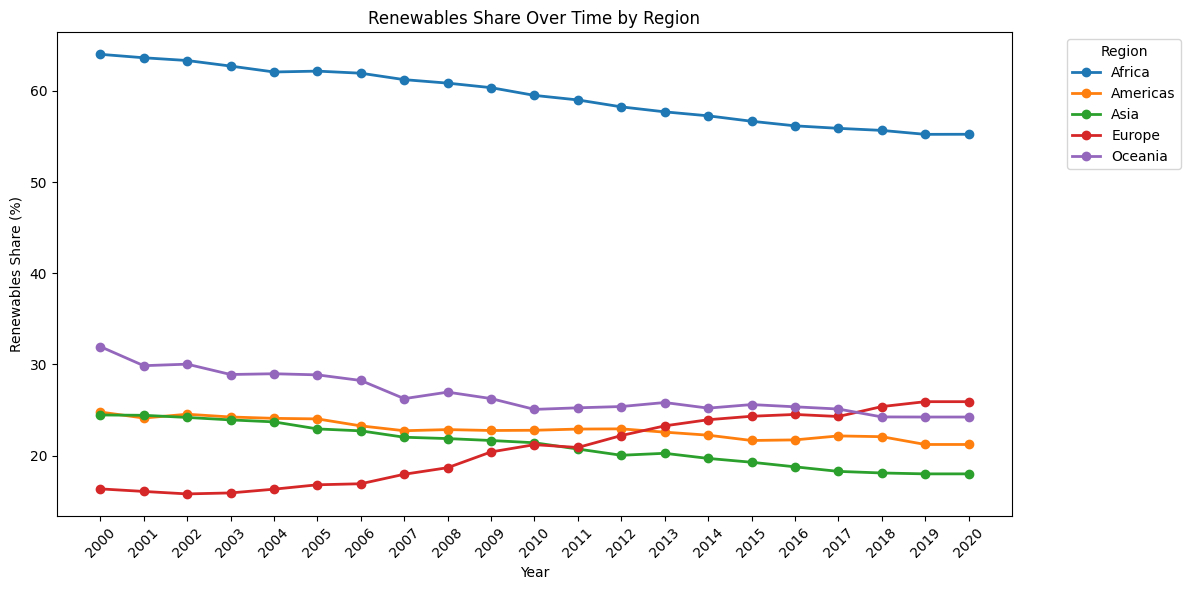

In [7]:
# Create line chart — renewables share over time by region

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")  

# Step 2: Filter relevant columns and drop NaNs
df_filtered = df[['year', 'region', 'renewables_share_pct']].dropna()

# Ensure year is integer for plotting
df_filtered['year'] = df_filtered['year'].astype(int)

# Step 3: Calculate average renewables share by region per year
df_line = (
    df_filtered
    .groupby(['year', 'region'])['renewables_share_pct']
    .mean()
    .reset_index()
    .pivot(index='year', columns='region', values='renewables_share_pct')
)

# Step 4: Plot line chart
plt.figure(figsize=(12, 6))
df_line.plot(kind='line', marker='o', linewidth=2, figsize=(12, 6))
plt.title('Renewables Share Over Time by Region')
plt.ylabel('Renewables Share (%)')
plt.xlabel('Year')

# Force x-axis ticks to be integers
plt.xticks(df_line.index, df_line.index.astype(int), rotation=45)

# Add legend and grid
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


In [19]:
# Create a plotly line chart — renewables share over time by subregion

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features.csv")
df_filtered = df[['year', 'subregion', 'renewables_share_pct']].dropna()
df_filtered['year'] = df_filtered['year'].astype(int)

# Group by year and subregion
df_grouped = (
    df_filtered
    .groupby(['year', 'subregion'])['renewables_share_pct']
    .mean()
    .reset_index()
)

# Plotly line chart
fig = px.line(
    df_grouped,
    x='year',
    y='renewables_share_pct',
    color='subregion',
    title='Renewables Share Over Time by Subregion',
    labels={
        'year': 'Year',
        'renewables_share_pct': 'Renewables Share (%)',
        'subregion': 'Subregion'
    },
    markers=False
)

# Update layout: rotate x-axis ticks and move legend to bottom
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tickangle=45
    ),
    legend_title='Subregion',
    height=600,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.3,         # Adjust if needed
        xanchor="center",
        x=0.5
    )
)

fig.show()


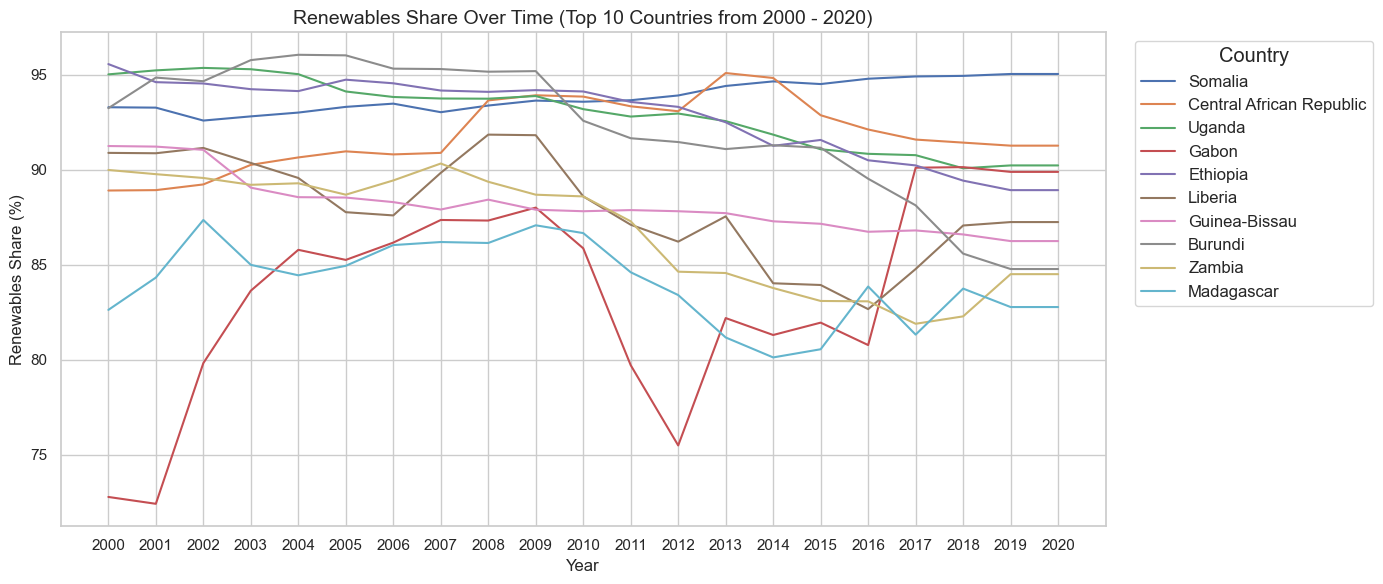

In [45]:
# Top 10 Countries by Renewables Share (%)

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Drop rows with missing values in target column
df = df.dropna(subset=['renewables_share_pct'])

# Make sure 'year' is integer
df['year'] = df['year'].astype(int)

# Get top 10 countries in 2020 by renewables share
df_2020 = df[df['year'] == 2020]
top10 = df_2020.nlargest(10, 'renewables_share_pct')['country'].tolist()

# Filter data for those countries
df_top10 = df[df['country'].isin(top10)]

# Plot
plt.figure(figsize=(14, 6))

for country in sorted(top10, key=lambda c: df_2020[df_2020['country'] == c]['renewables_share_pct'].values[0], reverse=True):
    df_country = df_top10[df_top10['country'] == country]
    plt.plot(df_country['year'], df_country['renewables_share_pct'], label=country)

# Force x-axis to show every year from 2000 to 2020 as integer
plt.xticks(ticks=list(range(2000, 2021)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Titles and labels
plt.title('Renewables Share Over Time (Top 10 Countries from 2000 - 2020)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Renewables Share (%)', fontsize=12)

# Increase legend size
plt.legend(title='Country', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='medium', title_fontsize='large')

plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import pandas as pd
import plotly.express as px

# Load  dataset
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Ensure year is an integer
df['year'] = df['year'].astype(int)

# Step 1: Get top 10 countries by renewables share in 2020
top10_countries = (
    df[df['year'] == 2020]
    .nlargest(10, 'renewables_share_pct')
    .sort_values('renewables_share_pct', ascending=False)
)['country'].tolist()

# Step 2: Filter dataset and avoid SettingWithCopyWarning
df_top10 = df[df['country'].isin(top10_countries)].copy()

# Reset index (help in avoiding some warnings)
df_top10.reset_index(drop=True, inplace=True)

# Explicitly set country order using .loc to avoid warning
df_top10.loc[:, 'country'] = pd.Categorical(
    df_top10['country'],
    categories=top10_countries,
    ordered=True
)

# Step 3: Create line chart with legend ordered
fig = px.line(
    df_top10,
    x='year',
    y='renewables_share_pct',
    color='country',
    title='Top 10 Countries by Renewables Share (%) Over Time',
    labels={
        'renewables_share_pct': 'Renewables Share (%)',
        'year': 'Year'
    },
    category_orders={'country': top10_countries},  # ensure proper legend order
)

# Step 4: Format chart layout
fig.update_layout(
    legend_title_text='Country',
    legend_traceorder='normal',
    legend=dict(
        font=dict(size=12),
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.01
    ),
    xaxis=dict(tickmode='linear', tick0=2000, dtick=2),
)

fig.show()


In [ ]:
# Top 15 Countries CO₂ Drop After 30% Renewables 

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
df['year'] = df['year'].astype(int)
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Step 1: Average CO₂ before and after tipping point
df_avg = (
    df.dropna(subset=['co2_per_capita_t', 'renewables_share_pct'])
      .groupby(['country', 'above_30_pct'], observed=True)['co2_per_capita_t']
      .mean()
      .reset_index()
)

# Step 2: Pivot to wide format
df_wide = df_avg.pivot(index='country', columns='above_30_pct', values='co2_per_capita_t').reset_index()
df_wide.columns = ['country', 'co2_before_30', 'co2_after_30']

# Step 3: Drop countries with missing values in either group
df_wide = df_wide.dropna(subset=['co2_before_30', 'co2_after_30'])

# Step 4: Calculate CO₂ change
df_wide['co2_change'] = df_wide['co2_after_30'] - df_wide['co2_before_30']

# Step 5: Get top 15 countries with largest CO₂ reduction (negative values)
top_reducers = df_wide.sort_values(by='co2_change').head(15)

# Step 6: Melt for grouped bar chart
df_melted = pd.melt(
    top_reducers,
    id_vars='country',
    value_vars=['co2_before_30', 'co2_after_30'],
    var_name='Threshold',
    value_name='Avg CO₂ per Capita'
)

# Step 7: Clean label
df_melted['Threshold'] = df_melted['Threshold'].map({
    'co2_before_30': 'Before 30%',
    'co2_after_30': 'After ≥30%'
})

# Step 8: Plot with Plotly
fig = px.bar(
    df_melted,
    x='country',
    y='Avg CO₂ per Capita',
    color='Threshold',
    barmode='group',
    title='Top 15 Countries: CO₂ Drop After Crossing 30% Renewables Threshold',
    labels={'country': 'Country'},
    category_orders={'Threshold': ['Before 30%', 'After ≥30%']}
)

fig.update_layout(
    xaxis_tickangle=45,
    legend_title_text='Tipping Point Status',
    yaxis_title='Average CO₂ per Capita (tonnes)',
    xaxis_title='',
    legend=dict(
        orientation='h',
        y=1.1,
        x=0.5,
        xanchor='center',
        yanchor='bottom'
    )
)

fig.show()


In [ ]:
# Visualising CO₂ Change by Subregion

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")
df['year'] = df['year'].astype(int)
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Step 1: Group by subregion and tipping point status
df_avg_subregion = (
    df.dropna(subset=['co2_per_capita_t', 'renewables_share_pct', 'subregion'])
      .groupby(['subregion', 'above_30_pct'], observed=True)['co2_per_capita_t']
      .mean()
      .reset_index()
)

# Step 2: Pivot and calculate change
df_wide_sub = df_avg_subregion.pivot(index='subregion', columns='above_30_pct', values='co2_per_capita_t').reset_index()
df_wide_sub.columns = ['subregion', 'co2_before_30', 'co2_after_30']
df_wide_sub = df_wide_sub.dropna()
df_wide_sub['co2_change'] = df_wide_sub['co2_after_30'] - df_wide_sub['co2_before_30']

# Sort before melting
df_wide_sub_sorted = df_wide_sub.sort_values(by='co2_change')

# Step 3: Melt for grouped bar chart
df_melted_sub = pd.melt(
    df_wide_sub_sorted,
    id_vars='subregion',
    value_vars=['co2_before_30', 'co2_after_30'],
    var_name='Threshold',
    value_name='Avg CO₂ per Capita'
)
df_melted_sub['Threshold'] = df_melted_sub['Threshold'].map({
    'co2_before_30': 'Before 30%',
    'co2_after_30': 'After ≥30%'
})

# Step 4: Plot
fig = px.bar(
    df_melted_sub,
    x='subregion',
    y='Avg CO₂ per Capita',
    color='Threshold',
    barmode='group',
    title='Subregion: CO₂ Drop After Crossing 30% Renewables Threshold',
    labels={'subregion': 'Subregion'},
    category_orders={'Threshold': ['Before 30%', 'After ≥30%']}
)

fig.update_layout(
    xaxis_tickangle=30,
    legend_title_text='Tipping Point Status',
    yaxis_title='Average CO₂ per Capita (tonnes)',
    xaxis_title='',
    legend=dict(
        orientation='h',
        y=1.1,
        x=0.5,
        xanchor='center',
        yanchor='bottom'
    )
)

fig.show()



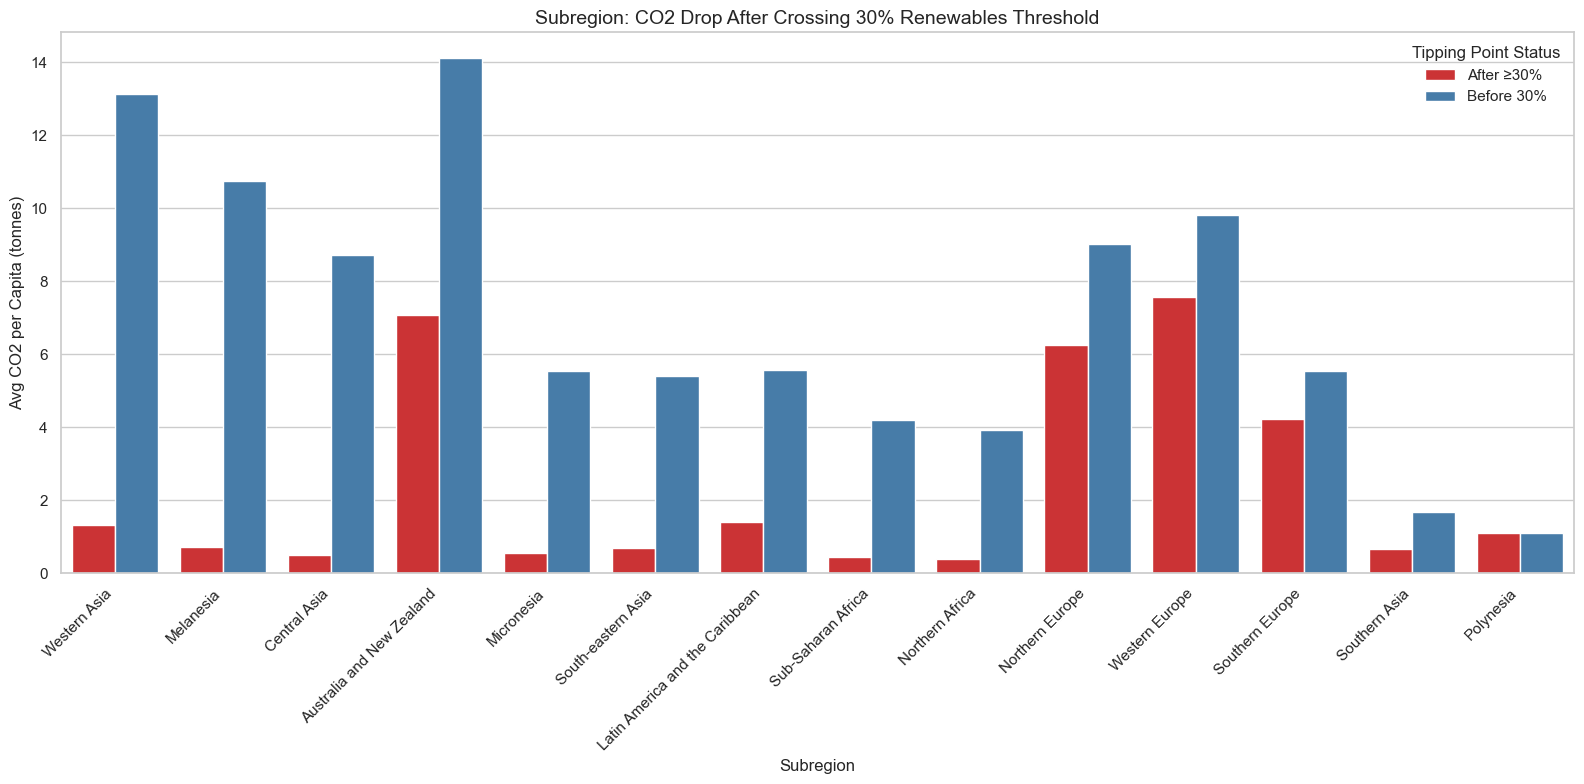

In [43]:
# Visualising CO₂ Change by Subregion 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Filter and prepare data
df_subregion = df.dropna(subset=['subregion', 'co2_per_capita_t']).copy()
df_subregion['Tipping Point Status'] = df_subregion['renewables_share_pct'].apply(
    lambda x: 'After ≥30%' if x >= 30 else 'Before 30%'
)

# Group by subregion and tipping point to calculate average CO2
avg_co2_subregion = (
    df_subregion.groupby(['subregion', 'Tipping Point Status'])['co2_per_capita_t']
    .mean()
    .reset_index()
    .rename(columns={'co2_per_capita_t': 'Avg CO2 per Capita (tonnes)'})
)

# Pivot to calculate CO2 drop (After - Before)
df_pivot = avg_co2_subregion.pivot(index='subregion', columns='Tipping Point Status', values='Avg CO2 per Capita (tonnes)')
df_pivot = df_pivot.dropna(subset=['Before 30%', 'After ≥30%'])  # Remove incomplete subregions
df_pivot['CO2 Change'] = df_pivot['After ≥30%'] - df_pivot['Before 30%']

# Sort subregions by CO2 change
subregion_order = df_pivot.sort_values(by='CO2 Change')['Before 30%'].index.tolist()

# Plot settings
plt.figure(figsize=(16, 8))
sns.set(style='whitegrid')

barplot = sns.barplot(
    data=avg_co2_subregion,
    x='subregion',
    y='Avg CO2 per Capita (tonnes)',
    hue='Tipping Point Status',
    order=subregion_order,
    palette='Set1'
)

# Titles and labels
plt.title("Subregion: CO2 Drop After Crossing 30% Renewables Threshold", fontsize=14)
plt.xlabel("Subregion")
plt.ylabel("Avg CO2 per Capita (tonnes)")
plt.xticks(rotation=45, ha='right')

# Move legend to top-right
plt.legend(
    title="Tipping Point Status",
    loc="upper right",
    bbox_to_anchor=(1.0, 1.0),
    frameon=False
)

plt.tight_layout()
plt.show()


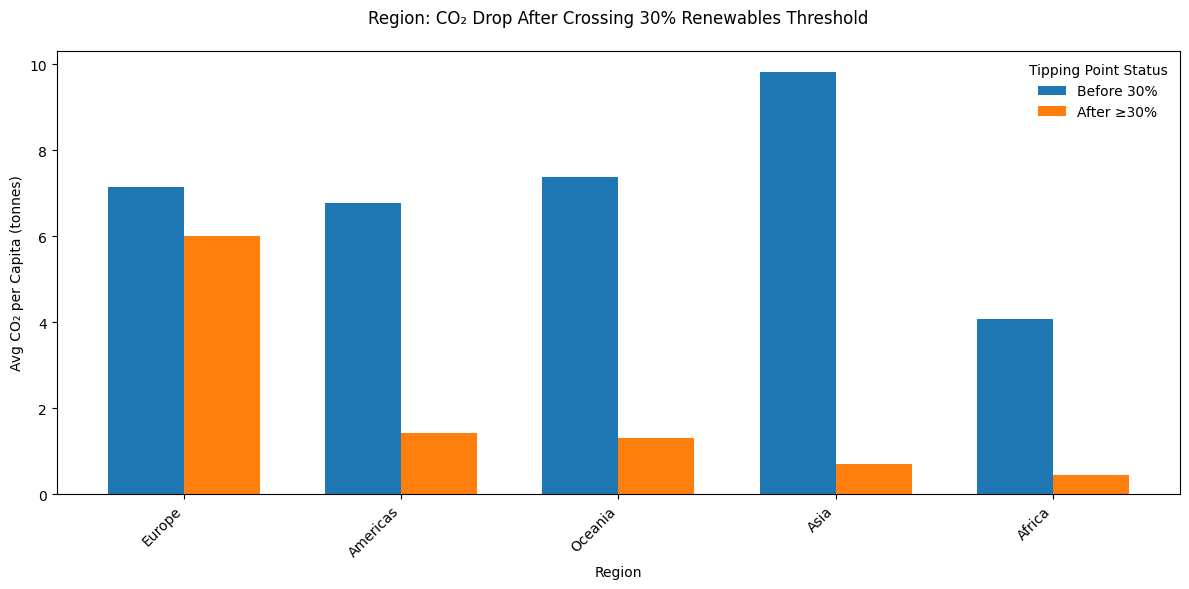

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

# Flag for 30% renewables tipping point
df['above_30_pct'] = df['renewables_share_pct'] >= 30

# Group by region and tipping point
df_avg = df.groupby(['region', 'above_30_pct'])['co2_per_capita_t'].mean().reset_index()
df_avg['Threshold'] = df_avg['above_30_pct'].map({True: 'After ≥30%', False: 'Before 30%'})

# Pivot data to wide format
pivot_df = df_avg.pivot(index='region', columns='Threshold', values='co2_per_capita_t')
pivot_df = pivot_df.sort_values(by='After ≥30%', ascending=False)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(pivot_df))

# Colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_before = colors[0]
color_after = colors[1]

# Bar charts
ax.bar(index, pivot_df['Before 30%'], bar_width, label='Before 30%', color=color_before)
ax.bar([i + bar_width for i in index], pivot_df['After ≥30%'], bar_width, label='After ≥30%', color=color_after)

# X-axis setup
ax.set_xlabel('Region')
ax.set_ylabel('Avg CO₂ per Capita (tonnes)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')

# Title above chart only (no overlap)
ax.set_title('Region: CO₂ Drop After Crossing 30% Renewables Threshold', pad=20)

# Legend inside the plot, inline with bars
legend_elements = [
    Patch(facecolor=color_before, label='Before 30%'),
    Patch(facecolor=color_after, label='After ≥30%')
]
ax.legend(
    handles=legend_elements,
    title='Tipping Point Status',
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=False
)

# Improve layout
plt.tight_layout()
plt.show()


In [44]:
# analyse global renewables share by country in 2020

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# load the dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Filter for the year 2020 and drop rows with missing renewables_share_pct
df_2020 = df[df['year'] == 2020].dropna(subset=['renewables_share_pct'])

# Create a choropleth map
fig = px.choropleth(
    df_2020,
    locations="country",
    locationmode="country names",
    color="renewables_share_pct",
    hover_name="country",
    color_continuous_scale="YlGnBu",
    title="Global Renewables Share by Country (2020)",
    labels={"renewables_share_pct": "Renewables Share (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Renewables Share (%)")
)

fig.show()


### Global Renewables Share by Country (2020)

This choropleth world map displays the percentage share of renewable energy in each country's total energy mix for the year 2020.

#### Key Interpretations

- **Dark Blue (70–100%)**: Countries with the highest reliance on renewables.
  - *Examples*: Several countries in **Sub-Saharan Africa** (e.g. Ethiopia, Kenya, Mozambique), and parts of **Scandinavia**.
  - These countries often rely heavily on **hydropower**, **biomass**, and in some cases **geothermal or wind**.

- **Medium Blue to Teal (30–70%)**: Countries with moderate renewable shares.
  - *Examples*: **Brazil**, **New Zealand**, and some countries in **Central Asia**.
  - These often have a diverse renewable portfolio or are transitioning toward cleaner energy sources.

- **Light Green to Yellow (0–30%)**: Countries with lower renewable penetration.
  - *Examples*: **United States**, **Australia**, **China**, and **Middle Eastern nations**.
  - These economies still rely heavily on **fossil fuels**, though some may have ambitious plans for renewables.


#### Regional Trends

- **Africa**: Many nations show high renewables shares, likely due to lower total energy demand combined with widespread use of traditional biomass and hydro.
- **Europe**: Mixed results—Nordic countries are leading, while parts of Eastern Europe lag behind.
- **Americas**: Brazil stands out with high renewables due to hydropower, while the U.S. and Canada remain in the mid-range.
- **Asia**: Variable patterns. Countries like Bhutan or Nepal (not clearly visible) may have high shares due to hydro, while large economies like China and India show moderate progress.
- **Oceania**: Australia has low renewable share, although this is increasing post-2020.


#### Overall Insight

The map reveals **global disparities in renewable energy adoption**. While some countries have made significant strides, especially where hydro or biomass is prevalent, major economies still have work to do to increase the share of renewables in their energy mix.


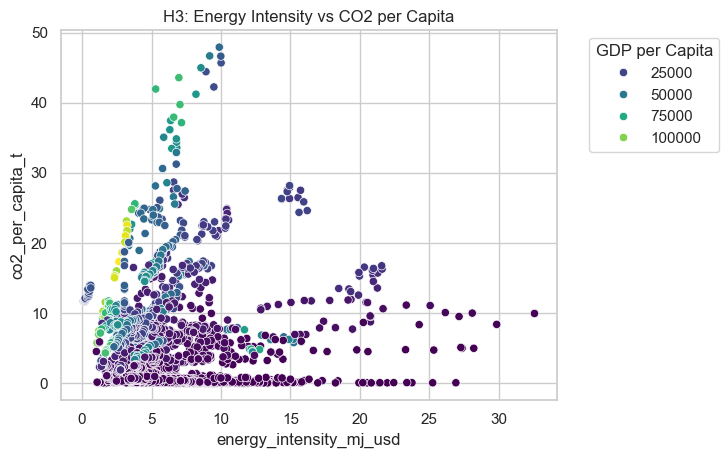

In [55]:
# H3: Visualise distributions -  Energy Intensity vs CO2 per Capita

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("../data/cleaned/enhanced_energy_features_final.csv")

sns.scatterplot(data=df, x='energy_intensity_mj_usd', y='co2_per_capita_t',
                hue='gdp_pc_usd', palette='viridis')
plt.title('H3: Energy Intensity vs CO2 per Capita')
plt.legend(title='GDP per Capita', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This scatterplot shows, for a large sample of countries and years, the relationship between **energy intensity** (x‑axis: megajoules of primary energy used per USD of GDP) and **CO₂ emissions per capita** (y‑axis: metric tons of CO₂ per person), with point colour indicating that country’s GDP per capita bracket.


**1. Two Very Different Clusters**

- **Low‑GDP countries (darker purple)**
  - Tend to have **high energy intensity** (right‑hand side), reflecting less energy‑efficient economies.
  - Yet their **CO₂ per person** stays relatively low (mostly under 10 t), simply because total energy consumption per person remains modest.

- **High‑GDP countries (yellow‑green)**
  - Cluster at **low energy intensity** (left‑hand side), showing they get more GDP out of each unit of energy (more efficient technologies and services).
  - Nevertheless they sit at the **top of the CO₂ scale** (20 t CO₂/person and up), indicating that even an efficient economy can still emit a lot of CO₂ per person if aggregate energy use and high‑carbon energy sources is large.


**2. Middle‑Income Economies Bridge the Gap**

- **Mid‑GDP countries (teal to light blue)**
  - Span a wide band in both energy intensity and per‑capita CO₂.
  - Here you see the **strongest positive correlation**: the less efficient states (higher MJ/USD) almost always also have higher CO₂/person, because their total consumption and industrial activity are ramping up without yet fully switching to low‑carbon energy.


**3. What this tell us?**

1. **Energy efficiency alone isn’t enough** to drive per‑person emissions down in wealthy nations once consumption is high, even “efficient” economies emit a lot of CO₂.  
2. **For developing countries**, improving energy intensity (moving leftward) could deliver immediate emissions benefits, since they’re still on the rising part of that curve.  
3. **Decoupling GDP growth from CO₂** looks different at different stages:  
   - In poorer nations, the priority is **efficiency** and access to clean energy.  
   - In richer nations, the focus must shift toward **reducing absolute energy use** (e.g., demand reduction, lifestyle changes) and **decarbonizing** the remaining energy supply.


- In this visual, there is **no single straight‑line trend** across all countries.
- **Energy intensity matters most** for mid and low income economies, where inefficiency directly drives emissions up.
- **Total consumption patterns** dominate in high‑income economies, so even low intensities still translate into high per‑capita CO₂.

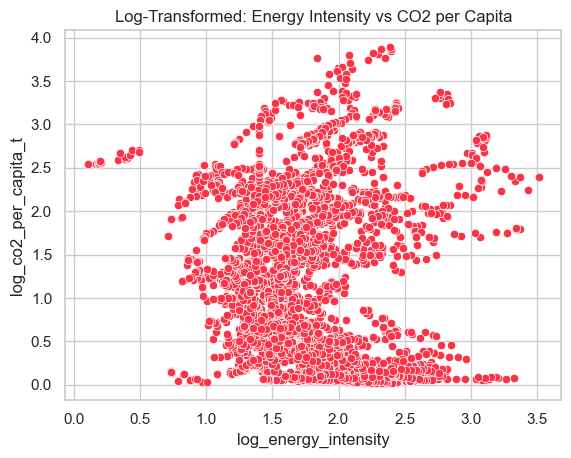

In [61]:
# Log-Transformed Scatterplot: Energy Intensity vs CO₂ per Capita

import numpy as np

# log transformation to identify skewed variables

df['log_co2_per_capita_t'] = np.log1p(df['co2_per_capita_t'])
df['log_energy_intensity'] = np.log1p(df['energy_intensity_mj_usd'])

# Plot after log transform
sns.scatterplot(data=df, x='log_energy_intensity', y='log_co2_per_capita_t', color= "#FA3347")
plt.title('Log-Transformed: Energy Intensity vs CO2 per Capita')
plt.show()


his scatter‑plot shows how a country’s energy intensity (energy use per unit of GDP) relates to its per person CO₂ emissions, with both axes on a log₁₀ scale.


**1. Axes & Scale**

- **Horizontal (x) axis:**  
  `log₁₀(energy intensity)`  
  - Value of **1** → energy intensity of 10 units/GDP‑unit  
  - Value of **2** → energy intensity of 100 units/GDP‑unit  

- **Vertical (y) axis:**  
  `log₁₀(CO₂ per capita)`  
  - Value of **2** → 100 t CO₂/person  
  - Value of **3** → 1 000 t CO₂/person  


**2. Overall Trend**

- There is a **moderately positive** relationship:  
  As energy intensity increases, CO₂ per capita tends to increase.  
- On a log–log plot, a straight‑line trend implies a **power‑law** relationship:  
  e.g. a 1 % increase in energy intensity corresponds to a roughly constant % increase in emissions per person.


**3. Scatter & Dispersion**

- **Wide spread** for `log EI ≈ 1.0–2.5` (EI ≈ 10–300):  
  Even at similar energy intensities, CO₂ per person varies a lot due to differences in fuel mix, climate, industry, transport, etc.
- **Low‑intensity economies** `(log EI < 1)` still show CO₂ per capita ranging from near zero up to mid‑range emitters.


**4. Clusters & Outliers**

- **Dense cluster** around  
  - `log EI ≈ 1.5–2.2` (EI ≈ 30–160)  
  - `log CO₂ ≈ 1.0–3.0` (CO₂ ≈ 10–1 000 t/person)  
  This is where most countries sit—moderate efficiency and moderate emissions.
  - **High‑emission outliers** at  
  - `log CO₂ ≈ 3.8–4.0` (≈ 6 000–10 000 t/person)  
  Likely small, energy‑exporting states or nations with very low population and heavy fossil‑fuel production.


**5. Policy Implications**

1. **Energy efficiency** (↓ energy intensity) tends to lower per‑capita CO₂, but it’s not sufficient alone.  
2. **Fuel mix matters**: Efficient economies can still emit heavily if they rely on coal or oil.  
3. **Decarbonization** (shifting to renewables) is needed to lower everyone’s per‑capita emissions, not just squeeze more out of fossil fuels.

In [62]:
# global trends -  reneewarble share, co2 emission pc and electricity access

import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

yearly = df.groupby('year').agg({
    'renewables_share_pct': 'mean',
    'co2_per_capita_t':    'mean',
    'elec_access_pct':     'mean'
}).reset_index()

yearly_long = yearly.melt(
    id_vars='year',
    value_vars=['renewables_share_pct','co2_per_capita_t','elec_access_pct'],
    var_name='Indicator',
    value_name='Value'
)

# Small multiples as columns, wrapped into one column
fig = px.line(
    yearly_long,
    x='year', y='Value',
    color='Indicator',
    facet_col='Indicator',
    facet_col_wrap=1,                # stack them vertically
    color_discrete_map={
        'renewables_share_pct': '#1f77b4',
        'co2_per_capita_t':      '#ff7f0e',
        'elec_access_pct':       '#2ca02c',
    },
    labels={'year':'Year','Value':''},
    title='Global Trends (2000–2020)'
)

# Let each subplot auto‑scale its Y‑axis
fig.update_yaxes(matches=None)

# insrt each title above its panel
fig.for_each_annotation(lambda a: a.update(
    text=a.text.split('=')[1]  # keep only the variable name
))

# Remove the extra subplot margin on the right
fig.update_layout(
    showlegend=False,
    margin=dict(t=80, b=40, l=40, r=40),
    title={'x':0.5}            # center main title
)

fig.show()

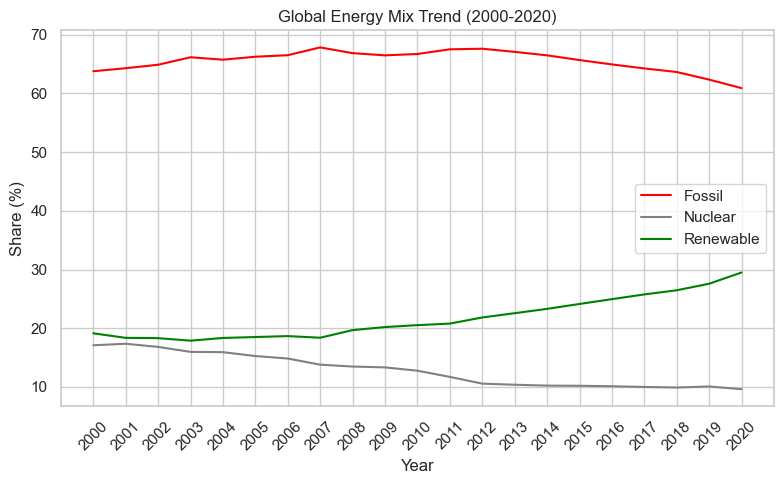

In [63]:
# Analyse global energy mix 
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/cleaned/enhanced_energy_features_final.csv')

# Compute global energy shares
global_agg = df.groupby('year').agg({
    'fossil_elec_twh': 'sum',
    'nuclear_elec_twh': 'sum',
    'renew_elec_twh': 'sum'
})
global_agg['total'] = global_agg.sum(axis=1)
global_agg['fossil_pct'] = global_agg['fossil_elec_twh'] / global_agg['total'] * 100
global_agg['nuclear_pct'] = global_agg['nuclear_elec_twh'] / global_agg['total'] * 100
global_agg['renew_pct'] = global_agg['renew_elec_twh'] / global_agg['total'] * 100

years = global_agg.index.astype(int)

plt.figure(figsize=(8, 5))
plt.plot(years, global_agg['fossil_pct'], label='Fossil', color='red')
plt.plot(years, global_agg['nuclear_pct'], label='Nuclear', color='grey')
plt.plot(years, global_agg['renew_pct'], label='Renewable', color='green')
plt.xlabel('Year')
plt.ylabel('Share (%)')
plt.title('Global Energy Mix Trend (2000-2020)')
plt.xticks(years, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 🌍 Global Energy Mix Trend (2000–2020)

This line chart illustrates the global share (%) of three primary energy sources—**Fossil**, **Nuclear**, and **Renewable** from 2000 to 2020.


#### 🔍 Key Observations:

- **🔴 Fossil Fuels**
  - Remained the dominant energy source throughout.
  - Peaked around **2007–2012** at ~68–69%.
  - Gradually declined to **~61% by 2020**.

- **⚫ Nuclear**
  - Declined steadily from **~18% in 2000** to **~10% in 2020**.
  - Suggests decreasing global reliance, possibly due to safety concerns or ageing infrastructure.

- **🟢 Renewables**
  - Increased steadily from **~18% in 2000** to **~30% by 2020**.
  - Growth notably accelerated post-2010, reflecting global transition efforts.


The chart reflects a **global energy transition**:
- **Renewables are on the rise**, driven by sustainability goals and technological advances.
- **Fossil fuels are declining**, though still dominant.
- **Nuclear energy is waning**, potentially due to policy shifts and public perception.

If current trends persist, renewables could continue closing the gap with fossil fuels, reshaping the global energy landscape.
